# Category Classification
The goal of this jupyter notebook is to try to predict the uveitis category of a patient based on lab test results. 

The hypothesis is that some lab tests results are indicative of a certain category of uveitis compared to other categories. This is to ascertain (or deny) that a or combination of lab result/s can be significant of which category of uveitis the patient is suffering from. 

Steps:
    
    
1. Get Subset of Data (Target Feature: Category, Input Features: Lab Results) 
2. Call preprocessing pipe with appropriate parameters
3. Fit Model
4. Extract and Discuss important Features



In [ ]:
# global Variables
RANDOM = 43

In [2]:
#import packages
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn

# sklearn standard imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Binarizer, LabelEncoder, Normalizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# import decision tree
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, f1_score, make_scorer

#imblearn processes
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# import of pipe module
os.chdir('../preprocessing/')
import pipe

In [3]:
# calling preprocessing function

# num_to_cat = True: Range Date is now dtype Category 
# drop_filter: first method keep all, second drop not lab results

df = pipe.preprocessing_pipe(
                             num_to_cat   = True,
                             #drop_filter  = ['hla', 'specific_diagnosis'], 
                             #drop_filter  = ['hla', 'loc', 'specific_diagnosis'], 
                             drop_filter  = ['hla', 'ac_', 'vit_', 'gender', 'race', 'loc','specific_diagnosis'],
                             loc_approach = 'multi',
                             binary_cat   = True
                             #hotencode_gender = True,
                             #hotencode_race = True
                            ) 

df

['rdw', 'rbc', 'lymphocytes_%', 'platelet_count', 'hemoglobin', 'complement_c3', 'mch', 'neutrophil_%', 'angiotensin_conv#enzyme', 'lactate_dehydrogenase', 'wbc', 'mchc', 'complement_c4', 'lysozyme,_plasma', 'hematocrit', 'mcv']


,cat,calcium,lactate_dehydrogenase,"c-reactive_protein,_normal_and_high_sensitivity",wbc,rbc,hemoglobin,hematocrit,mcv,mch,...,anti-ena_screen,antinuclear_antibody,complement_c3,complement_c4,dna_double-stranded_ab,rheumatoid_factor,hbc__ab,hbs__ag,hcv__ab,uveitis
0,not_uveitis,2.27,1.0,1.830,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0,0,0,0,False
1,idiopathic,2.32,1.0,0.150,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0,0,0,0,True
2,systemic,2.44,1.0,0.137,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0,0,0,0,True
3,idiopathic,2.45,1.0,3.500,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0,0,0,0,True
4,idiopathic,2.28,1.0,1.000,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,infectious,2.26,1.0,15.400,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0,0,0,0,True
1071,idiopathic,2.36,1.0,0.800,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0,0,0,0,True
1072,infectious,2.26,1.0,0.600,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0,0,0,0,True
1073,wds,2.41,1.0,6.970,2.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0,0,0,0,True


In [4]:
print("missing in target are", df['cat'].isnull().sum())
percentil_cat = df.cat.value_counts(dropna=False)/len(df)
percentil_cat

missing in target are 0


idiopathic                  0.493482
systemic                    0.178771
not_uveitis                 0.131285
wds                         0.115456
infectious                  0.081006
scleritis                   0.000000
nonneoplastic masquerade    0.000000
neoplastic masquerade       0.000000
Name: cat, dtype: float64

In [5]:
df_t = df.copy().dropna()
features = df_t.drop(columns=['cat', 'uveitis']) # all features excluded target
target = df_t['cat'].cat.codes # target

# train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.25, random_state = RANDOM, stratify = None)
X_train, X_test, y_train, y_test 
scorer = make_scorer(f1_score, average = 'macro')

In [6]:
# filter for numeric and categorical features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
category = ['category','bool']

# select list of numeric and categorical features
numeric_features = features.select_dtypes(include=numerics).columns.tolist()
categorical_features = features.select_dtypes(include=category).columns.tolist()

# define imputer strategy (consult sklarn SimpleImputer and StandardScaler documentation for options)
imputer = {'categorical':{'strategy':'most_frequent','fill_value':'most_frequent'}, 'numerical':{'strategy':'median', 'fill_value':'mean'}}
imputer_encoder = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot = False)

Accuracy: 0.16605296343001258
              precision    recall  f1-score   support

           0       0.48      0.50      0.49        90
           1       0.00      0.00      0.00        20
           4       0.10      0.11      0.10        19
           6       0.12      0.09      0.10        22
           7       0.11      0.18      0.13        17

    accuracy                           0.31       168
   macro avg       0.16      0.17      0.17       168
weighted avg       0.30      0.31      0.30       168

{'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 12}


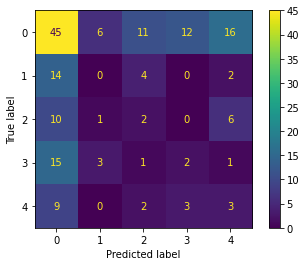

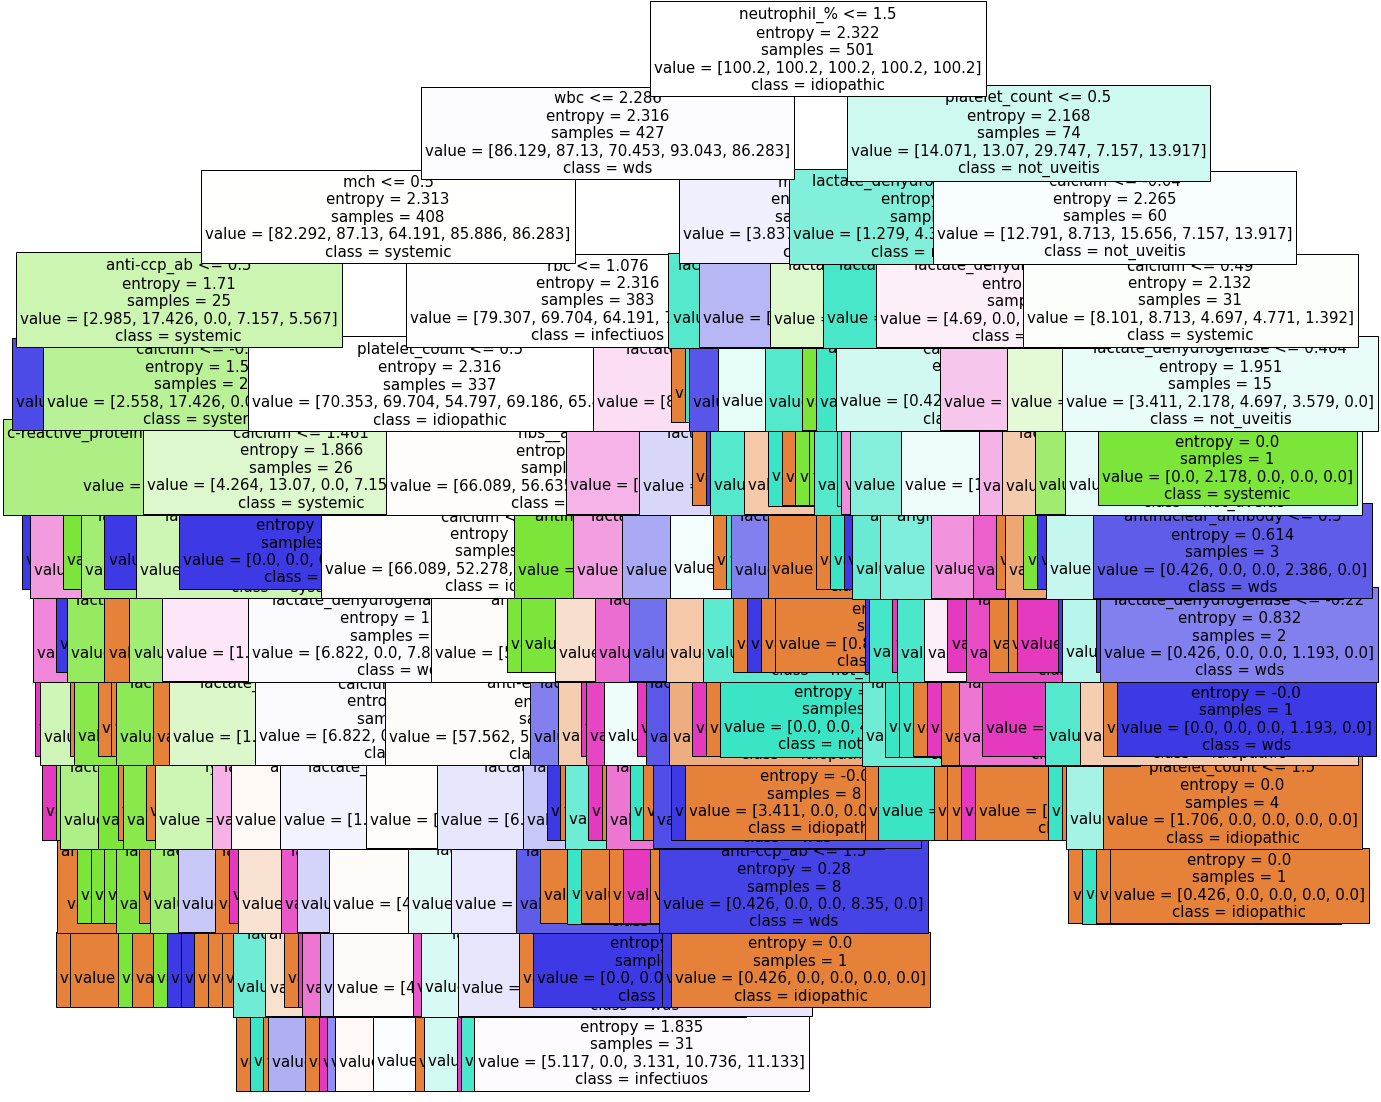

In [7]:
dectree = DecisionTreeClassifier()

pipeline = Pipeline(steps=[('preprocessor', imputer_encoder),
                      ('classifier', dectree)])

criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
class_weight = ["balanced"] #[{"idiopathic":0.49, "systemic":0.18, "not_uveitis":0.13, "wds":0.12, "infectious":0.08}]

parameters = {
             'classifier__criterion':criterion,
             'classifier__max_depth':max_depth,
             'classifier__class_weight':class_weight
             }

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, parameters, cv = 10, scoring = scorer)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: target_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot();
print(cv.best_params_);

plt.figure(figsize=(20,20))
class_names = ['idiopathic', 'systemic', 'not_uveitis', 'wds', 'infectiuos']
feature_names = X_test.columns.tolist()
plot_tree(cv.best_estimator_[1], fontsize=15, class_names=class_names, feature_names=feature_names, filled=True)
plt.show()

In [8]:
df_over = df.copy().dropna()
X = df_over.drop(columns=['cat', 'uveitis']) # all features excluded target
y = df_over['cat'].cat.codes # target

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = RANDOM, stratify = None)

In [9]:
# filter for numeric and categorical features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
category = ['category','bool']

# select list of numeric and categorical features
numeric_features = X.select_dtypes(include=numerics).columns.tolist()
categorical_features = X.select_dtypes(include=category).columns.tolist()

# define imputer strategy (consult sklarn SimpleImputer and StandardScaler documentation for options)
imputer = {'categorical':{'strategy':'most_frequent','fill_value':'most_frequent'}, 'numerical':{'strategy':'median', 'fill_value':'mean'}}
imputer_encoder = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot = False)

In [10]:
#sorted(sklearn.metrics.SCORERS.keys())

Accuracy: 0.3869047619047619
              precision    recall  f1-score   support

           0       0.52      0.64      0.57        90
           1       0.16      0.20      0.18        20
           4       0.10      0.11      0.10        19
           6       0.00      0.00      0.00        22
           7       0.12      0.06      0.08        17

    accuracy                           0.39       168
   macro avg       0.18      0.20      0.19       168
weighted avg       0.32      0.39      0.35       168

{'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': 6}


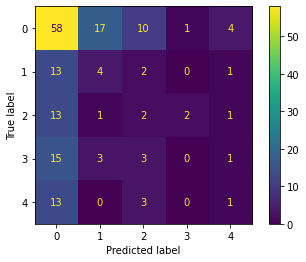

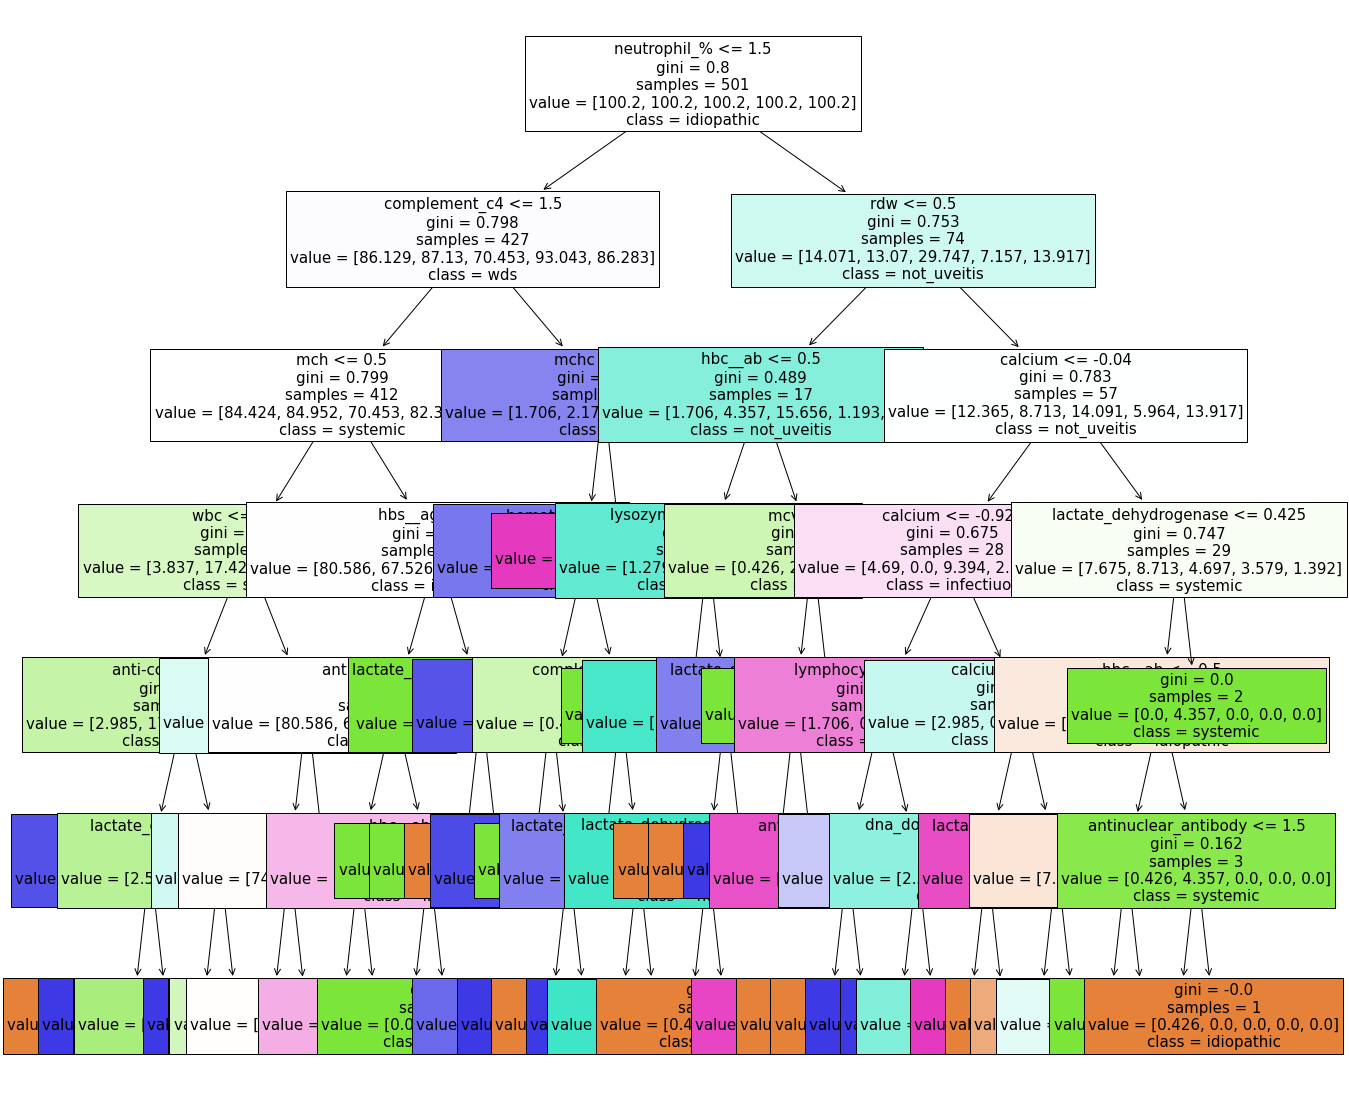

In [11]:
pipeline = Pipeline(steps=[('preprocessor', imputer_encoder),
                      ('classifier', dectree)])

criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
class_weight = ["balanced"] #[{"idiopathic":0.49, "systemic":0.18, "not_uveitis":0.13, "wds":0.12, "infectious":0.08}]

parameters = {
             'classifier__criterion':criterion,
             'classifier__max_depth':max_depth,
             'classifier__class_weight':class_weight
             }

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, parameters, cv = 10)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: target_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot();
print(cv.best_params_);

plt.figure(figsize=(20,20))
class_names = ['idiopathic', 'systemic', 'not_uveitis', 'wds', 'infectiuos']
feature_names = X_test.columns.tolist()
plot_tree(cv.best_estimator_[1], fontsize=15, class_names=class_names, feature_names=feature_names, filled=True)
plt.show()